# 1. Data Understanding

## Import File

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dilaaurafutri","key":"36c86ec01398d67b389bb7800cd10579"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d 'CooperUnion/anime-recommendations-database'
!unzip anime-recommendations-database.zip

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
  0% 0.00/25.0M [00:00<?, ?B/s]
100% 25.0M/25.0M [00:00<00:00, 1.54GB/s]
Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


In [5]:
# load the dataset
anime = pd.read_csv('anime.csv')
ratings = pd.read_csv('rating.csv')

print('Jumlah anime : ', len(anime))
print('Jumlah rating : ', len(ratings))

Jumlah anime :  12294
Jumlah rating :  7813737


# 2. Univariate Exploratory Data Analysis
Variabel-variabel pada dataset anime adalah sebagai berikut:

- anime_id – ID unik dari MyAnimeList.net yang mengidentifikasi sebuah anime.

- name – Nama lengkap dari anime.

- genre – Daftar genre anime yang dipisahkan dengan koma.

- type – Jenis anime, seperti movie, TV, OVA, dll.

- episodes – Jumlah episode dari anime tersebut (bernilai 1 jika merupakan film).

- rating – Rata-rata penilaian dari pengguna terhadap anime ini (dari skala 1 sampai 10).

- members – Jumlah anggota komunitas yang menjadi bagian dari "grup" anime ini.


Variabel-variabel pada dataset Rating :
- user_id – ID pengguna yang dihasilkan secara acak dan tidak dapat diidentifikasi.

- anime_id – ID anime yang telah diberi rating oleh pengguna ini.

- rating – Penilaian yang diberikan pengguna terhadap anime ini (bernilai -1 jika pengguna telah menonton anime tetapi tidak memberikan rating).

## Tujuan

Pada proyek ini, beberapa variabel akan di eksplorasi. Variabel anime_id akan digunakan untuk mapping, variabel rating digunakan untuk membentuk matriks user-item dan akan diolah oleh algoritma Collaborative Filtering untuk mencari kesamaan antar pengguna sedangkan variabel name akan digunakan untuk hasil output rekomendasi.

## Eksplorasi Variabel Animes

In [6]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [7]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [8]:
print("Banyak data: ", len(anime["anime_id"]))
print("Nama anime yang tersedia: ", anime.name.unique())
print("Type anime yang tersedia: ", anime.type.unique())
print("Genre yang tersedia: ", anime.genre.unique())

Banyak data:  12294
Nama anime yang tersedia:  ['Kimi no Na wa.' 'Fullmetal Alchemist: Brotherhood' 'Gintama°' ...
 'Violence Gekiga David no Hoshi'
 'Violence Gekiga Shin David no Hoshi: Inma Densetsu'
 'Yasuji no Pornorama: Yacchimae!!']
Type anime yang tersedia:  ['Movie' 'TV' 'OVA' 'Special' 'Music' 'ONA' nan]
Genre yang tersedia:  ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' ...
 'Hentai, Sports' 'Drama, Romance, School, Yuri' 'Hentai, Slice of Life']


In [9]:
#misisng values
print('Jumlah Genre : ', len(anime.genre.unique()))
print('Jumlah Type : ', len(anime.type.unique()))
print('Jumlah Rating : ', len(anime.rating.unique()))

Jumlah Genre :  3265
Jumlah Type :  7
Jumlah Rating :  599


**Hasil eksplorasi:**
- Ada 7 kolom dalam dataset anime
- Jumlah seluruh baris adalah 12.294
- Ada 4 variabel bertipe data object, 2 integer dan 1 float
- Ada missing value pada variabel genre, tipe dan rating

## Eksplorasi Variabel Ratings

In [10]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [11]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [12]:
ratings.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [13]:
print('Jumlah user yang memberikan rating : ', len(ratings['user_id'].unique()))
print('Jumlah anime yang memiliki rating : ', len(ratings.anime_id.unique()))
print('Jumlah data rating: ', len(ratings["rating"].unique()))

Jumlah user yang memberikan rating :  73515
Jumlah anime yang memiliki rating :  11200
Jumlah data rating:  11


# 3. Data Preprocessing

## Menggabungkan Anime

In [14]:
import numpy as np

# Menggabungkan seluruh anime_id pada kategori Restaurant
anime_all = np.concatenate((
    anime.anime_id.unique(),
    ratings.anime_id.unique()
))

# Mengurutkan data dan menghapus data yang sama
anime_all = np.sort(np.unique(anime_all))

print('Jumlah seluruh data anime berdasarkan anime_id: ', len(anime_all))

Jumlah seluruh data anime berdasarkan anime_id:  12297


In [15]:
all_anime = pd.merge(ratings, anime[['anime_id', 'name', 'genre']], on='anime_id', how='left')
all_anime

,user_id,anime_id,rating,name,genre
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P..."
1,1,24,-1,School Rumble,"Comedy, Romance, School, Shounen"
2,1,79,-1,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R..."
3,1,226,-1,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,..."
4,1,241,-1,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School"
...,...,...,...,...,...
7813732,73515,16512,7,Devil Survivor 2 The Animation,"Action, Demons, Supernatural"
7813733,73515,17187,9,Ghost in the Shell: Arise - Border:1 Ghost Pain,"Mecha, Police, Psychological, Sci-Fi"
7813734,73515,22145,10,Kuroshitsuji: Book of Circus,"Comedy, Demons, Fantasy, Historical, Shounen, ..."
7813735,73516,790,9,Ergo Proxy,"Mystery, Psychological, Sci-Fi"


# 4. Data Preparation

**Anime**

In [16]:
# Cek missing value dengan fungsi isnull()
anime.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [17]:
# Tangani missing value
anime['genre'] = anime['genre'].fillna('Unknown')
anime['type'] = anime['type'].fillna('Unknown')
anime = anime.dropna(subset=['rating'])  # Hapus rating NaN (optional)

# Cek ulang
print(anime.isnull().sum())


anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


**Rating**

In [18]:
# Cek missing value dengan fungsi isnull()
ratings.isnull().sum()

,0
user_id,0
anime_id,0
rating,0


In [19]:
# Hapus rating -1 (menonton tapi tidak memberikan rating)
ratings = ratings[ratings['rating'] >= 0]
ratings

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


**Encode user_id dan anime_id**


In [20]:
# Ambil user_id dan anime_id unik, ubah ke list
user_ids = ratings['user_id'].unique().tolist()
anime_ids = ratings['anime_id'].unique().tolist()

# Buat dictionary: user_id → index
user_to_encoded = {x: i for i, x in enumerate(user_ids)}
encoded_to_user = {i: x for i, x in enumerate(user_ids)}

# Buat dictionary: anime_id → index
anime_to_encoded = {x: i for i, x in enumerate(anime_ids)}
encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}


**Mapping hasil encoding ke DataFrame**

In [21]:
# Mapping ID asli ke index
ratings['user'] = ratings['user_id'].map(user_to_encoded)
ratings['anime'] = ratings['anime_id'].map(anime_to_encoded)


**Informasi dasar jumlah data**

In [22]:
num_users = len(user_to_encoded)
num_animes = len(anime_to_encoded)

min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()

print(f'Jumlah user: {num_users}, Jumlah anime: {num_animes}')
print(f'Rating minimum: {min_rating}, Rating maksimum: {max_rating}')


Jumlah user: 69600, Jumlah anime: 9927
Rating minimum: 1, Rating maksimum: 10


## Anime
Mengatasi Missing Value

In [23]:
# Mengecek kembali missing value pada variabel all_anime_clean
all_anime.isnull().sum()

,0
user_id,0
anime_id,0
rating,0
name,10
genre,120


In [24]:
# Membersihkan missing value dengan fungsi dropna()
all_anime_clean = all_anime.dropna()
all_anime_clean

,user_id,anime_id,rating,name,genre
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P..."
1,1,24,-1,School Rumble,"Comedy, Romance, School, Shounen"
2,1,79,-1,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R..."
3,1,226,-1,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,..."
4,1,241,-1,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School"
...,...,...,...,...,...
7813732,73515,16512,7,Devil Survivor 2 The Animation,"Action, Demons, Supernatural"
7813733,73515,17187,9,Ghost in the Shell: Arise - Border:1 Ghost Pain,"Mecha, Police, Psychological, Sci-Fi"
7813734,73515,22145,10,Kuroshitsuji: Book of Circus,"Comedy, Demons, Fantasy, Historical, Shounen, ..."
7813735,73516,790,9,Ergo Proxy,"Mystery, Psychological, Sci-Fi"


In [25]:
# Mengecek kembali missing value pada variabel all_anime_clean
all_anime_clean.isnull().sum()

,0
user_id,0
anime_id,0
rating,0
name,0
genre,0


In [36]:
# Mengurutkan buku berdasarkan anime_id kemudian memasukkannya ke dalam variabel fix_anime
fix_anime = all_anime_clean.sort_values('anime_id', ascending=True)
fix_anime

,user_id,anime_id,rating,name,genre
4232776,40121,1,9,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
7169652,66854,1,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
7169628,66853,1,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
6198506,57945,1,5,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
849745,7758,1,9,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
...,...,...,...,...,...
1456909,13954,34475,6,Monster Strike: Rain of Memories,"Action, Fantasy, Game"
5704639,53492,34475,5,Monster Strike: Rain of Memories,"Action, Fantasy, Game"
7558121,70768,34475,-1,Monster Strike: Rain of Memories,"Action, Fantasy, Game"
5106536,48766,34476,-1,Platonic Chain: Ansatsu Jikkouchuu,"Sci-Fi, Slice of Life"


## Mengatasi Data Duplikat

In [37]:
# Membuang data duplikat pada variabel preparation
preparation = fix_anime.drop_duplicates('anime_id')
preparation

,user_id,anime_id,rating,name,genre
4232776,40121,1,9,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
4233165,40124,5,-1,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space"
1192435,11358,6,9,Trigun,"Action, Comedy, Sci-Fi"
5422434,51218,7,8,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna..."
3682785,34422,8,-1,Beet the Vandel Buster,"Adventure, Fantasy, Shounen, Supernatural"
...,...,...,...,...,...
3316425,30565,34367,6,Long Riders Recap,"Comedy, Shounen, Slice of Life, Sports"
7703451,72404,34412,-1,Hashiri Hajimeta bakari no Kimi ni,Music
7535009,70547,34475,9,Monster Strike: Rain of Memories,"Action, Fantasy, Game"
5106536,48766,34476,-1,Platonic Chain: Ansatsu Jikkouchuu,"Sci-Fi, Slice of Life"


In [38]:
# Menghapus anime yang memiliki rating -1 dan 0
preparation = preparation[preparation['rating'] >= 1]
preparation

,user_id,anime_id,rating,name,genre
4232776,40121,1,9,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
1192435,11358,6,9,Trigun,"Action, Comedy, Sci-Fi"
5422434,51218,7,8,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna..."
7622073,71505,15,10,Eyeshield 21,"Action, Comedy, Shounen, Sports"
6080735,57053,16,7,Hachimitsu to Clover,"Comedy, Drama, Josei, Romance"
...,...,...,...,...,...
7689953,72253,34240,8,Shelter,"Music, Sci-Fi"
3648334,34071,34252,10,STAR BEAT!: Hoshi no Kodou,Music
7485225,69964,34325,8,Pokemon XY&amp;Z Specials,"Action, Adventure, Comedy, Fantasy, Kids"
3316425,30565,34367,6,Long Riders Recap,"Comedy, Shounen, Slice of Life, Sports"


In [39]:
# Mengecek berapa jumlah fix_anime
len(fix_anime.anime_id.unique())

11165

Konversi ke **list**

In [40]:
# Mengonversi data series 'anime_id' menjadi dalam bentuk list
id = preparation['anime_id'].tolist()

# Mengonversi data series ‘name’ menjadi dalam bentuk list
anime_name = preparation['name'].tolist()

# Mengonversi data series ‘genre’ menjadi dalam bentuk list
anime_genre = preparation['genre'].tolist()


print(len(id))
print(len(anime_name))
print(len(anime_genre))

7252
7252
7252


In [41]:
# Membuat dictionary untuk data ‘d’, ‘anime_name’, ‘anime_genre’
anime_new = pd.DataFrame({
    'id': id,
    'anime_name': anime_name,
    'anime_genre': anime_genre
})
anime_new


,id,anime_name,anime_genre
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
1,6,Trigun,"Action, Comedy, Sci-Fi"
2,7,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna..."
3,15,Eyeshield 21,"Action, Comedy, Shounen, Sports"
4,16,Hachimitsu to Clover,"Comedy, Drama, Josei, Romance"
...,...,...,...
7247,34240,Shelter,"Music, Sci-Fi"
7248,34252,STAR BEAT!: Hoshi no Kodou,Music
7249,34325,Pokemon XY&amp;Z Specials,"Action, Adventure, Comedy, Fantasy, Kids"
7250,34367,Long Riders Recap,"Comedy, Shounen, Slice of Life, Sports"


## Membagi Data untuk Training dan Validasi

In [42]:
# Mengacak dataset
df = ratings.sample(frac=1, random_state=42)
df

,user_id,anime_id,rating,user,anime
5656992,53103,6707,7,50245,774
3552500,32884,339,8,31108,523
2636208,24907,23755,9,23560,80
5554182,52213,10156,7,49405,2505
95779,994,1562,10,934,790
...,...,...,...,...,...
1937731,18814,14713,7,17766,1427
2745907,25830,10397,8,24436,311
6086891,57108,12255,7,54062,2787
5325494,50462,226,9,47717,848


In [43]:
# Normalisasi rating (0–1)
min_rating = df['rating'].min()
max_rating = df['rating'].max()

x = df[['user', 'anime']].values
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * df.shape[0])
x_train, x_val = x[:train_indices], x[train_indices:]
y_train, y_val = y[:train_indices], y[train_indices:]


# 4. Model Development dengan Collaborative Filtering

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class AnimeRecommender(tf.keras.Model):
    def __init__(self, num_users, num_anime, embedding_size=20):
        super(AnimeRecommender, self).__init__()
        self.user_embedding = layers.Embedding(num_users, embedding_size)
        self.user_bias = layers.Embedding(num_users, 1)
        self.anime_embedding = layers.Embedding(num_anime, embedding_size)
        self.anime_bias = layers.Embedding(num_anime, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        anime_vector = self.anime_embedding(inputs[:, 1])
        anime_bias = self.anime_bias(inputs[:, 1])

        dot_user_anime = tf.reduce_sum(user_vector * anime_vector, axis=1, keepdims=True)
        return tf.nn.sigmoid(dot_user_anime + user_bias + anime_bias)

# Inisialisasi model
num_users = len(user_to_encoded)
num_anime = len(anime_to_encoded)

model = AnimeRecommender(num_users, num_anime)
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


**Train Model**

In [45]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=256
)


Epoch 1/5
19804/19804 ━━━━━━━━━━━━━━━━━━━━ 132s 7ms/step - loss: 0.6471 - root_mean_squared_error: 0.2706 - val_loss: 0.5507 - val_root_mean_squared_error: 0.1714
Epoch 2/5
19804/19804 ━━━━━━━━━━━━━━━━━━━━ 135s 6ms/step - loss: 0.5411 - root_mean_squared_error: 0.1597 - val_loss: 0.5273 - val_root_mean_squared_error: 0.1432
Epoch 3/5
19804/19804 ━━━━━━━━━━━━━━━━━━━━ 149s 7ms/step - loss: 0.5252 - root_mean_squared_error: 0.1401 - val_loss: 0.5221 - val_root_mean_squared_error: 0.1368
Epoch 4/5
19804/19804 ━━━━━━━━━━━━━━━━━━━━ 149s 7ms/step - loss: 0.5204 - root_mean_squared_error: 0.1343 - val_loss: 0.5199 - val_root_mean_squared_error: 0.1340
Epoch 5/5
19804/19804 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - loss: 0.5184 - root_mean_squared_error: 0.1318 - val_loss: 0.5187 - val_root_mean_squared_error: 0.1324


proses training model cukup smooth, kita memperoleh nilai error akhir sebesar sekitar 0.1318 dan error pada data validasi sebesar 0.1324. Nilai tersebut cukup bagus untuk sistem rekomendasi.

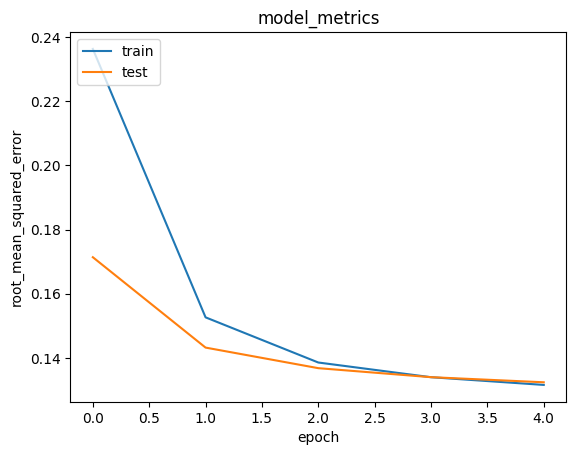

In [46]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# 5. Prediksi Rekomendasi Anime untuk 1 User

In [47]:
import numpy as np

anime_df = anime_new        # dataframe berisi info anime
df = pd.read_csv('rating.csv')
ratings = ratings

# Ambil 1 sample user
user_id = ratings['user_id'].sample(1).iloc[0]

# Ambil anime yang sudah ditonton user
anime_watch_by_user = ratings[ratings['user_id'] == user_id]

# Ambil anime yang belum ditonton user
anime_not_watch = anime_df[~anime_df['id'].isin(anime_watch_by_user['anime_id'])]['id']

# Intersect dengan anime yang ada di dictionary encoded
anime_not_watch = list(set(anime_not_watch).intersection(set(anime_to_encoded.keys())))

# Ubah jadi format input untuk prediksi (user_id, anime_id)
anime_not_watch_encoded = [[anime_to_encoded[x]] for x in anime_not_watch]
user_encoded = user_to_encoded[user_id]
user_anime_array = np.hstack((np.full((len(anime_not_watch_encoded), 1), user_encoded), anime_not_watch_encoded))


In [51]:
# Prediksi rating untuk anime yang belum ditonton user
predicted_ratings = model.predict(user_anime_array).flatten()

# Ambil indeks dari top 10 rating tertinggi
top_ratings_indices = predicted_ratings.argsort()[-10:][::-1]

# Ambil anime_id asli dari hasil rekomendasi
# Corrected: Access the original anime ID directly from the anime_not_watch list
recommended_anime_ids = [
    anime_not_watch[i] for i in top_ratings_indices
]

print('Menampilkan rekomendasi untuk user:', user_id)
print('=' * 30)

print('\nAnime dengan rating tertinggi dari user:')
print('-' * 30)

# 5 anime dengan rating tertinggi dari user tersebut
top_anime_user = (
    anime_watch_by_user.sort_values(by='rating', ascending=False)
    .head(5)
    .anime_id.values
)

top_anime_rows = anime_df[anime_df['id'].isin(top_anime_user)]
for row in top_anime_rows.itertuples():
    print(f"{row.anime_name} | Genre: {row.anime_genre}")

print('-' * 30)
print('Top 10 Rekomendasi Anime:')
print('-' * 30)

# Ambil informasi anime dari hasil rekomendasi
recommended_anime = anime_df[anime_df['id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(f"{row.anime_name} | Genre: {row.anime_genre}")

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
Menampilkan rekomendasi untuk user: 59401

Anime dengan rating tertinggi dari user:
------------------------------
Rose of Versailles | Genre: Adventure, Drama, Historical, Romance, Shoujo
Mind Game | Genre: Adventure, Comedy, Dementia, Psychological, Romance
Kaiba | Genre: Adventure, Mystery, Romance, Sci-Fi
Zetsuen no Tempest | Genre: Action, Drama, Fantasy, Magic, Mystery, Psychological, Shounen
------------------------------
Top 10 Rekomendasi Anime:
------------------------------
Monster | Genre: Drama, Horror, Mystery, Police, Psychological, Seinen, Thriller
Ginga Eiyuu Densetsu | Genre: Drama, Military, Sci-Fi, Space
Gintama | Genre: Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen
Fullmetal Alchemist: Brotherhood | Genre: Action, Adventure, Drama, Fantasy, Magic, Military, Shounen
Steins;Gate | Genre: Sci-Fi, Thriller
Gintama&#039; | Genre: Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen
Hunter x Hunter (2011) 